[*********************100%***********************]  3 of 3 completed

Price           Close                               High              \
Ticker            AGG         GLD         SPY        AGG         GLD   
Date                                                                   
2020-01-09  98.950737  146.029999  302.845184  98.950737  146.410004   
2020-01-10  99.117401  146.910004  301.973694  99.126169  146.990005   
2020-01-13  99.056007  145.820007  304.050446  99.082325  146.380005   
2020-01-14  99.143715  145.690002  303.586945  99.152483  145.809998   

Price                         Low                               Open  \
Ticker             SPY        AGG         GLD         SPY        AGG   
Date                                                                   
2020-01-09  302.919370  98.661226  145.440002  301.797529  98.687544   
2020-01-10  303.596162  98.977030  146.169998  301.500880  99.047215   
2020-01-13  304.059698  98.985822  145.779999  302.168384  99.038458   
2020-01-14  304.671664  99.073529  145.080002  303.021384  99.1

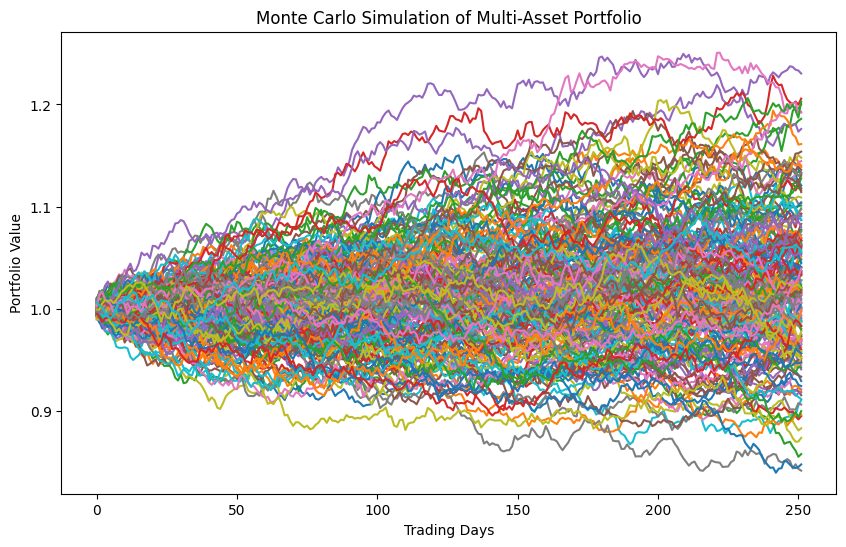

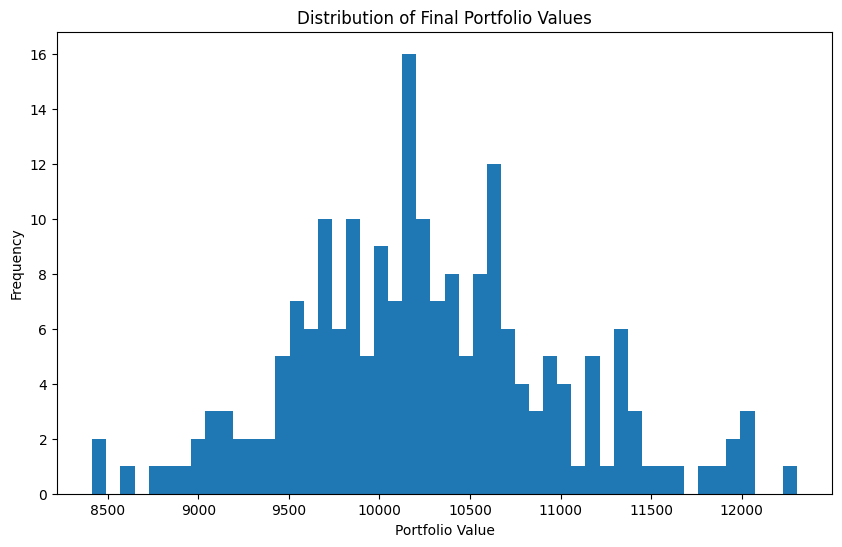

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Download data for multiple assets
tickers = ['SPY', 'AGG', 'GLD']  # S&P 500, Aggregate Bond, Gold
data = yf.download(tickers, period="5y")

# Check if 'Close' column is present
if 'Close' not in data.columns.levels[0]:
    raise KeyError("'Close' column not found in the downloaded data. Available columns: {}".format(data.columns.levels[0]))

# Preview the data
print(data.head(4))
print(data.tail(4))

# Print column names
print(data.columns)

# Print the date range of the data
print("Data covers the period from {} to {}".format(data.index.min(), data.index.max()))

# Extract 'Close' prices
close_data = data['Close']

# Calculate returns
returns = np.log(data / data.shift(1))

# Calculate mean returns and covariance matrix for 'Close' prices only
mean_returns = returns['Close'].mean()
cov_matrix = returns['Close'].cov()

# Function to calculate portfolio return and volatility
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std

# Monte Carlo simulation function
def monte_carlo_simulation(weights, mean_returns, cov_matrix, mc_sims, T):
    # Generate correlated random returns
    corr_matrix = np.linalg.cholesky(cov_matrix)
    
    # Initialize array to store simulation results
    sim_returns = np.zeros((T, mc_sims))
    
    for m in range(mc_sims):
        Z = np.random.standard_normal((len(weights), T))
        L = np.matmul(corr_matrix, Z)
        daily_returns = mean_returns.values[:, np.newaxis] + L
        sim_returns[:, m] = np.cumprod(np.dot(weights, np.exp(daily_returns)))
    
    return sim_returns

# Set simulation parameters
weights = np.array([0.85, 0, 0.15])  # Example weights
mc_sims = 200  # Number of simulations
T = 252  # Number of trading days (1 year)

# Run Monte Carlo simulation
sim_results = monte_carlo_simulation(weights, mean_returns, cov_matrix, mc_sims, T)

# Calculate portfolio metrics
initial_portfolio_value = 10000  # Starting with $10,000
final_portfolio_values = initial_portfolio_value * sim_results[-1, :]

mean_final_value = np.mean(final_portfolio_values)
var_95 = np.percentile(final_portfolio_values, 5)
cvar_95 = np.mean(final_portfolio_values[final_portfolio_values <= var_95])

# Print results
print(f"Expected portfolio value after 1 year: ${mean_final_value:.2f}")
print(f"95% VaR: ${initial_portfolio_value - var_95:.2f}")
print(f"95% CVaR: ${initial_portfolio_value - cvar_95:.2f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sim_results)
plt.title('Monte Carlo Simulation of Multi-Asset Portfolio')
plt.xlabel('Trading Days')
plt.ylabel('Portfolio Value')
plt.show()

# Histogram of final portfolio values
plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=50)
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.show()